In [17]:
!pip install kneed

In [18]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

# Basic configuration
DATE_CONFIG = {
    'TRAIN_START': pd.Timestamp('2021-02-02'),
    'TRAIN_END': pd.Timestamp('2024-01-01'),
    'TEST_END': pd.Timestamp('2025-01-01'),
    'TRADING_DAYS_PER_YEAR': 252  
}

def get_training_period():
    return {
        'start': DATE_CONFIG['TRAIN_START'],
        'end': DATE_CONFIG['TRAIN_END']
    }

def get_test_period():
    return {
        'start': DATE_CONFIG['TRAIN_END'],
        'end': DATE_CONFIG['TEST_END']
    }

def get_training_days():
    years = (DATE_CONFIG['TRAIN_END'] - DATE_CONFIG['TRAIN_START']).days / 365
    return int(years * DATE_CONFIG['TRADING_DAYS_PER_YEAR'])

# Plot settings
plt.style.use('classic')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [19]:
def load_and_prepare_data(file_path):

    df = pd.read_parquet(file_path)
    df['date'] = pd.to_datetime(df['date'])
    
    mask = (df['date'] >= DATE_CONFIG['TRAIN_START']) & \
           (df['date'] <= DATE_CONFIG['TEST_END'])
    df = df[mask]
    
    price_matrix = df.pivot(index='date', columns='symbol', values='close')
    
    symbols = price_matrix.columns.tolist()
    
    print(f"Loaded data from {DATE_CONFIG['TRAIN_START']} to {DATE_CONFIG['TEST_END']}")
    print(f"Total symbols: {len(symbols)}")
    print(f"Total trading days: {len(price_matrix)}")
    
    return price_matrix, symbols

##### Loade Price Data

In [20]:
price_matrix, symbols = load_and_prepare_data('./sim_daily.parquet')

Loaded data from 2021-02-02 00:00:00 to 2025-01-01 00:00:00
Total symbols: 100
Total trading days: 1022



$$ \text{Rendite} = \frac{1}{T} \sum_{t=1}^{T} \frac{P_t - P_{t-1}}{P_{t-1}} \times \text{Trading days per year} $$


$$ \text{Volatilität} = \sqrt{\frac{1}{T-1} \sum_{t=1}^{T} \left( \frac{P_t - P_{t-1}}{P_{t-1}} - \mu \right)^2} \times \sqrt{\text{Trading days per year}} $$


In [21]:
def calculate_metrics(price_matrix):
    returns = price_matrix.pct_change().mean() * DATE_CONFIG['TRADING_DAYS_PER_YEAR']
    metrics = pd.DataFrame(returns, columns=['returns'])
    metrics['volatility'] = price_matrix.pct_change().std() * np.sqrt(DATE_CONFIG['TRADING_DAYS_PER_YEAR'])
    return metrics

##### Validate metrics

In [22]:
metrics = calculate_metrics(price_matrix)
print("Erste 5 Zeilen der Metriken:")
print(metrics.head())
print("\nBeschreibung der Metriken:")
print(metrics.describe())

Erste 5 Zeilen der Metriken:
         returns  volatility
symbol                      
ADDRO  -0.076502    0.580353
AFIWZ   0.227020    0.609729
AFQOF   0.303274    0.602475
AQDMB   0.365647    0.593355
ATIYU   0.051473    0.603368

Beschreibung der Metriken:
          returns  volatility
count  100.000000  100.000000
mean    -0.013424    0.601099
std      0.320235    0.012271
min     -0.680621    0.574813
25%     -0.202954    0.593685
50%      0.014260    0.600100
75%      0.203040    0.610001
max      0.740925    0.627592


##### Scale Transform
The StandardScaler transforms our features (returns and volatility) to have zero mean and unit variance, which eliminates the scale difference between our variables and prevents higher magnitude features from dominating. This standardization is crucial for many machine learning algorithms as it ensures that all features contribute equally to the model and helps prevent numerical instabilities during the optimization process.

In [23]:
def scale_metrics(metrics):
    scaler = StandardScaler()
    scaled = pd.DataFrame(
        scaler.fit_transform(metrics),
        columns=metrics.columns,
        index=metrics.index
    )
    return scaled

In [24]:
X = scale_metrics(metrics)
print("Erste 5 Zeilen der skalierten Daten:")
print(X.head())
print("\nBeschreibung der skalierten Daten:")
print(X.describe())

Erste 5 Zeilen der skalierten Daten:
         returns  volatility
symbol                      
ADDRO  -0.197966   -1.699223
AFIWZ   0.754620    0.706827
AFQOF   0.993938    0.112715
AQDMB   1.189690   -0.634296
ATIYU   0.203676    0.185847

Beschreibung der skalierten Daten:
            returns    volatility
count  1.000000e+02  1.000000e+02
mean  -2.553513e-17 -1.556533e-15
std    1.005038e+00  1.005038e+00
min   -2.093955e+00 -2.152964e+00
25%   -5.948273e-01 -6.072121e-01
50%    8.688601e-02 -8.180786e-02
75%    6.793608e-01  7.291535e-01
max    2.367477e+00  2.169941e+00


# K-Means

##### Find Number of Clusters

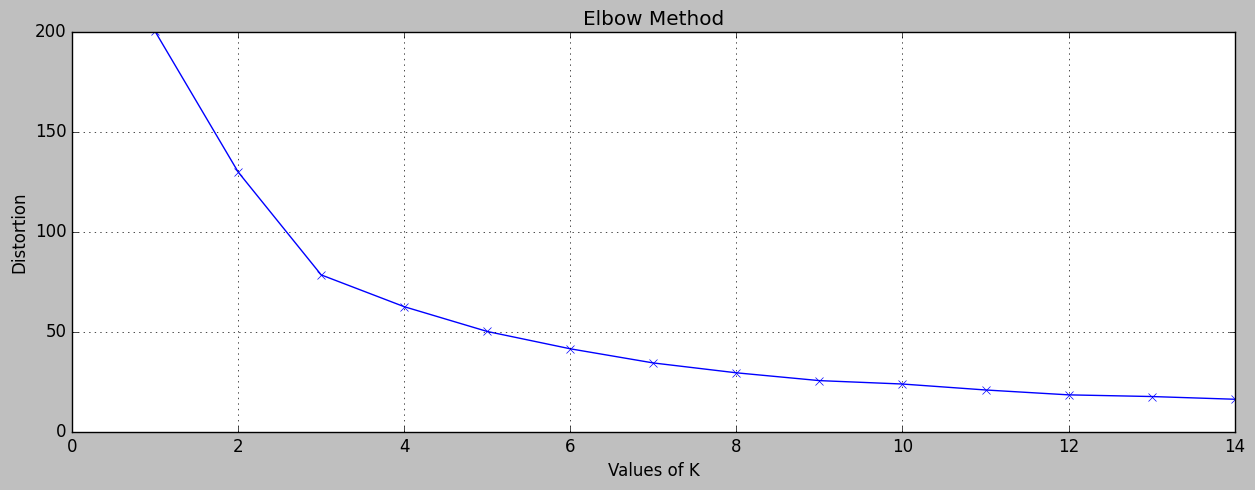

Suggested number of clusters:  4


In [25]:
K = range(1,15)
distortions = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', kl.elbow)

##### Build Cluster

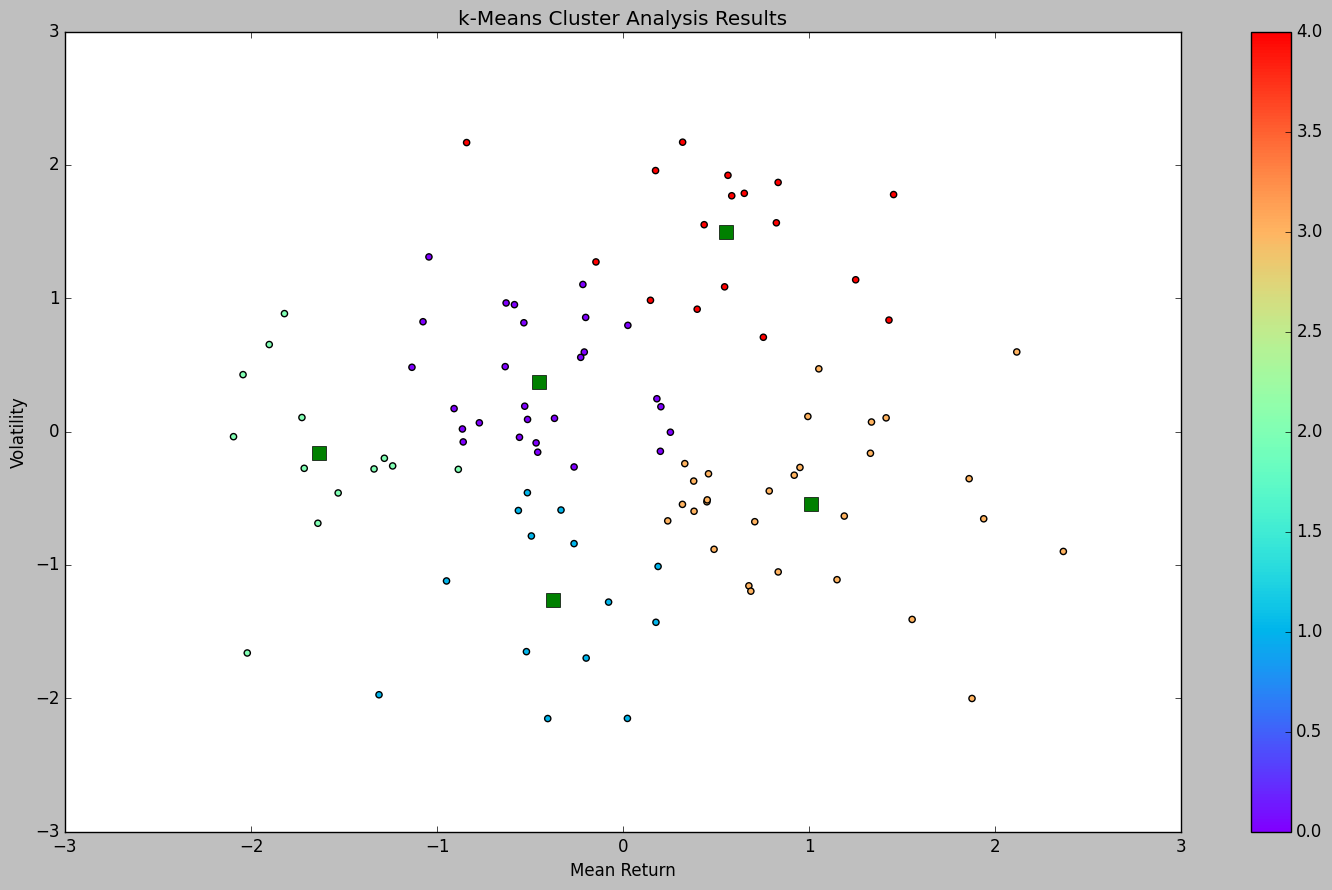

In [ ]:
c = 4
#Fit the model
k_means = KMeans(n_clusters=c, random_state=42, n_init=10, init='random')  # gleiche Parameter wie vorher
k_means.fit(X)
prediction = k_means.predict(X)

#Plot the results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label = X.index)
ax.set_title('k-Means Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0], centroids[:,1], 'sg', markersize=10)
plt.show()

#### Number auf Stock Pairs per Cluster

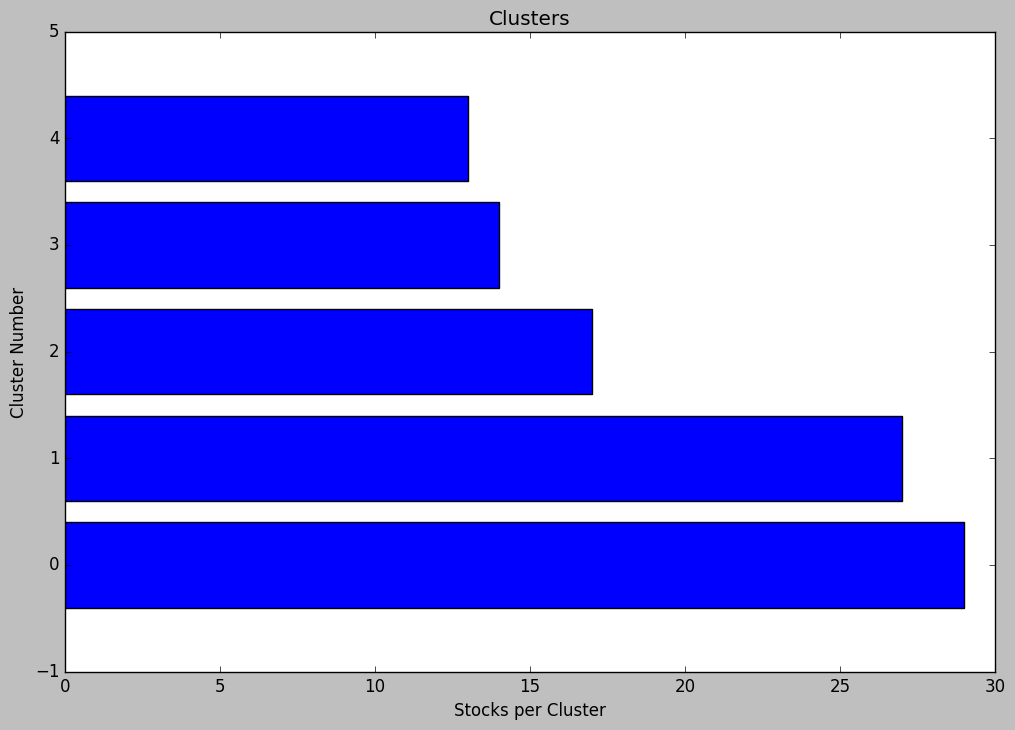

In [27]:
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]

plt.figure(figsize=(12,8))
plt.barh(range(len(clustered_series.value_counts())), clustered_series.value_counts())
plt.title('Clusters')
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()

# Hierarchical Clustering

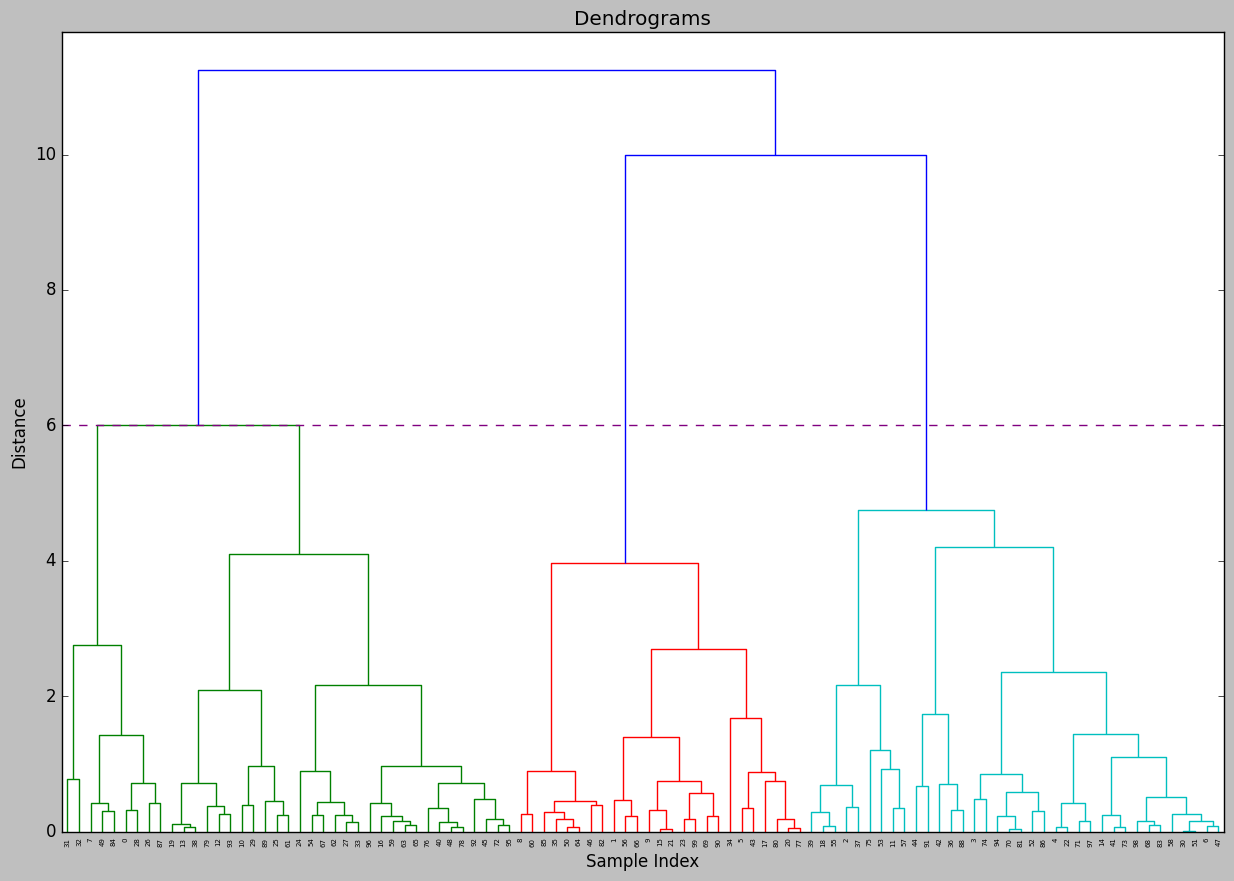

In [28]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(15, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))

plt.axhline(y=6, color='purple', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

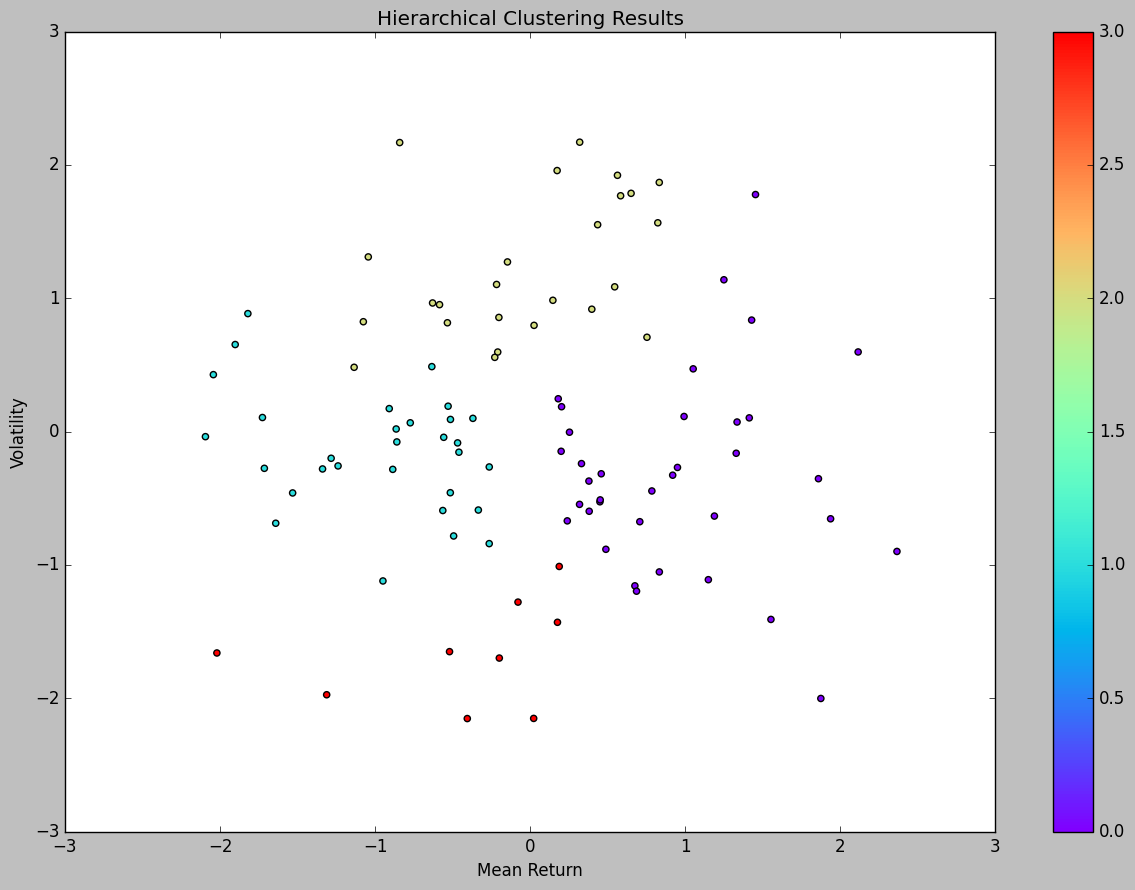

In [ ]:
clusters = 5
hc = AgglomerativeClustering(n_clusters=clusters)
labels = hc.fit_predict(X)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels, cmap='rainbow')
ax.set_title('Hierarchical Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

# Affinity Propagation Clustering

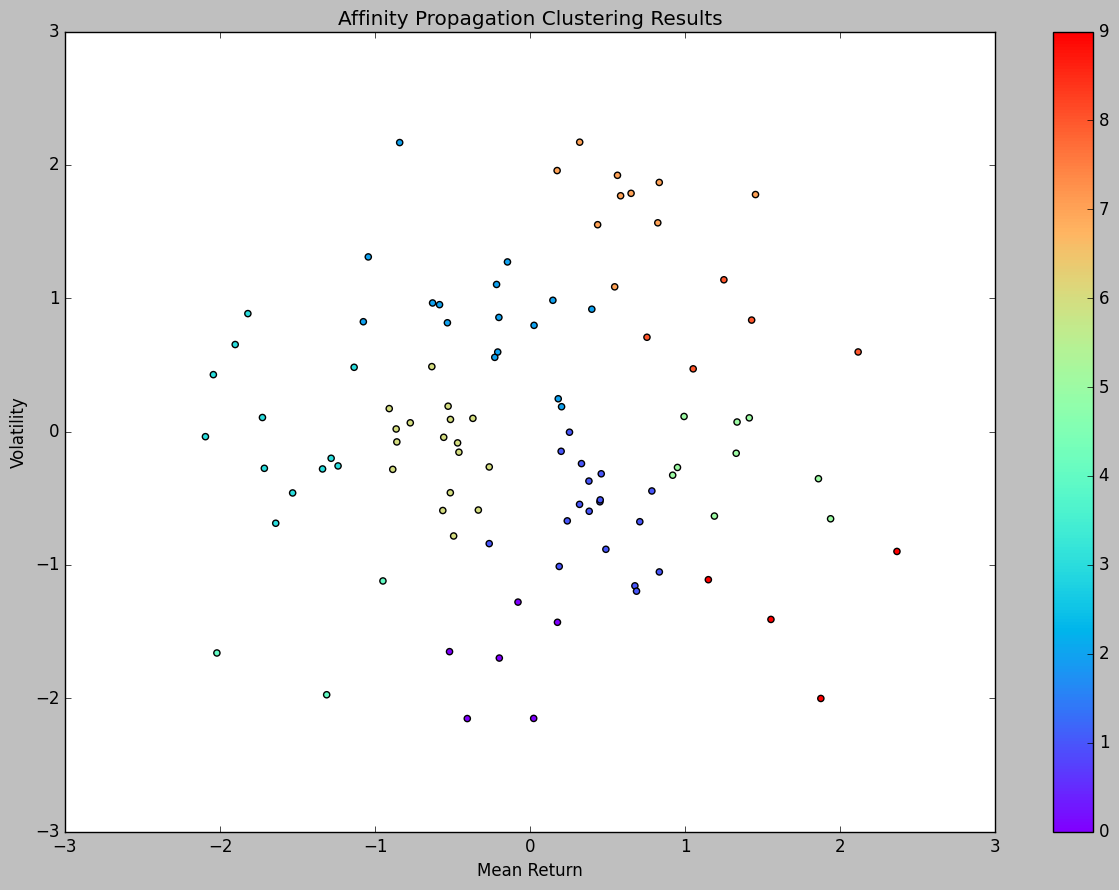

In [30]:
ap = AffinityPropagation()
ap.fit(X)
labels1 = ap.predict(X)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels1, cmap='rainbow')
ax.set_title('Affinity Propagation Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

The number of clusters is: 10


<Figure size 1200x600 with 0 Axes>

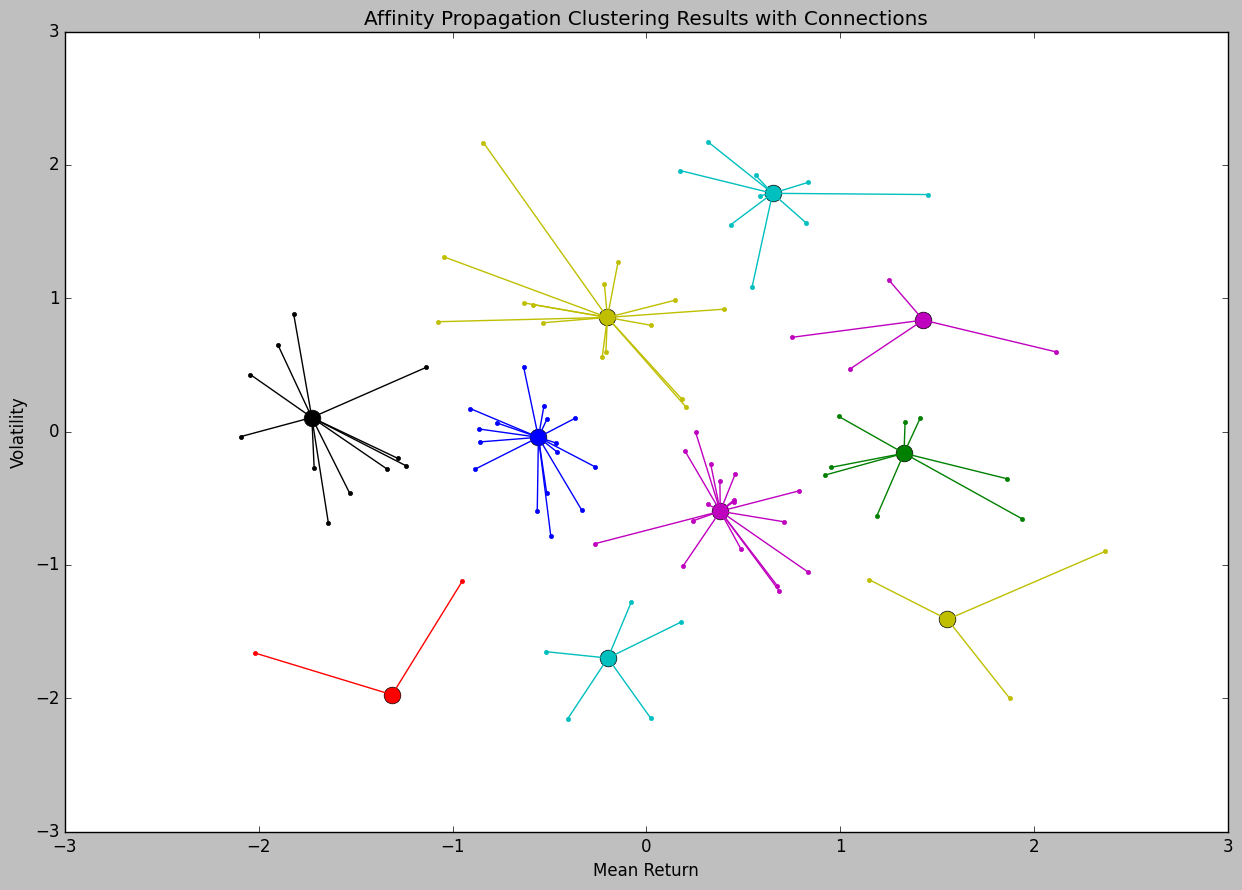

In [31]:
from itertools import cycle

#Extract the cluster centers and labels
cci = ap.cluster_centers_indices_
labels2 = ap.labels_

#Print their number
clusters = len(cci)
print('The number of clusters is:',clusters)

#Plot the results
X_ap = np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf
fig=plt.figure(figsize=(15,10))
colors = cycle('cmykrgbcmykrgbcmykrgbcmykrgb')
for k, col in zip(range(clusters),colors):
    cluster_members = labels2 == k
    cluster_center = X_ap[cci[k]]
    plt.plot(X_ap[cluster_members, 0], X_ap[cluster_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=12)
    for x in X_ap[cluster_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Affinity Propagation Clustering Results with Connections')
plt.xlabel('Mean Return')
plt.ylabel('Volatility')
plt.show()

In [32]:
from sklearn import metrics

print("k-Means Clustering", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("Hierarchical Clustering", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("Affinity Propagation Clustering", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

k-Means Clustering 0.35284222330418324
Hierarchical Clustering 0.3537857919935007
Affinity Propagation Clustering 0.3663741871861357
